### Importing required packages:

In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

### Loading Dataset

In [3]:
accident_data = pd.read_csv('C:\\Users\megha\OneDrive - UNT System\Desktop\Capstone_project\Capstone_finaldataset.csv',encoding='latin1')

In [4]:
print(accident_data.columns)

Index(['crash_date', 'borough', 'zip_code', 'latitude', 'longitude',
       'collision_id', 'crash_time_period', 'contributing_factor_vehicles',
       'vehicle_types', 'number_of_injuries', 'number_of_deaths',
       'street_name', 'street_type', 'weather_description', 'precipitation',
       'precipitation_type', 'temp_max', 'temp_min'],
      dtype='object')


### Formatting crash_date to datetime

In [5]:
accident_data['crash_date'] = pd.to_datetime(accident_data['crash_date'], errors='coerce')

### Data Cleaning

#### Handling missing values in columns (weather, severity, location)

In [7]:
accident_data_cleaned = accident_data.dropna(subset=['borough', 'weather_description', 'number_of_injuries', 'number_of_deaths']).copy()

# Ensure weather_description doesn't contain string lists or 'Unspecified' strings
accident_data_cleaned = accident_data_cleaned[~accident_data_cleaned['weather_description'].str.contains('Unspecified', na=False)]

# Create a binary target variable for accident severity (1: Serious accident, 0: Not serious)
accident_data_cleaned['serious_accident'] = (accident_data_cleaned['number_of_injuries'] > 0) | (accident_data_cleaned['number_of_deaths'] > 0)

### Numerical summary of the key columns

In [9]:
accident_data_cleaned.describe()

,crash_date,zip_code,latitude,longitude,collision_id,number_of_injuries,number_of_deaths,precipitation,temp_max,temp_min
count,468659,468650.000000,458812.000000,458812.000000,4.686590e+05,468659.000000,468659.000000,468659.000000,468659.000000,468659.000000
mean,2020-07-19 11:32:23.471052288,10879.330934,40.541636,-73.579357,4.309022e+06,0.745092,0.003721,1.779084,18.339118,10.948196
min,2019-01-01 00:00:00,10000.000000,0.000000,-74.254845,3.822228e+06,0.000000,0.000000,0.000000,-7.300000,-14.500000
25%,2019-08-02 00:00:00,10454.000000,40.667084,-73.962580,4.182944e+06,0.000000,0.000000,0.000000,9.400000,3.300000
50%,2020-04-13 00:00:00,11208.000000,40.717648,-73.919235,4.309191e+06,0.000000,0.000000,0.230000,19.200000,11.200000
75%,2021-07-04 00:00:00,11354.000000,40.780730,-73.863434,4.434983e+06,2.000000,0.000000,1.168000,27.100000,19.300000
max,2023-12-31 00:00:00,11697.000000,40.912884,0.000000,4.693082e+06,40.000000,8.000000,71.630000,36.700000,26.900000
std,NaN,533.219587,2.734457,4.961334,1.457173e+05,1.461301,0.090229,4.507620,9.937939,9.159501


### Exploratory Data Analysis(EDA):

#### Accident Severity Distribution-shows the distribution of accidents by severity.

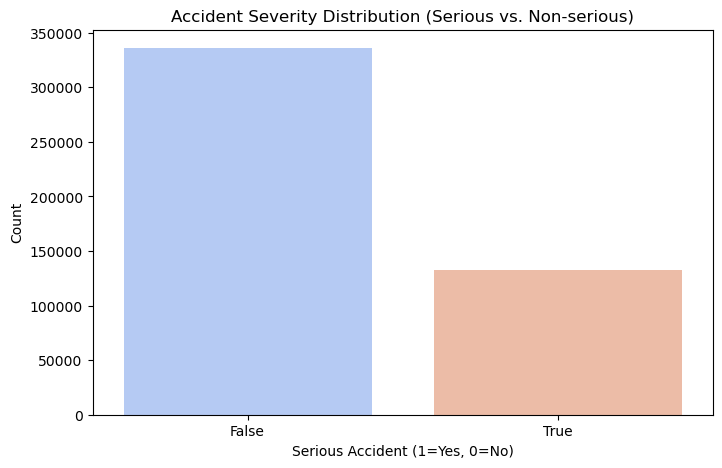

In [13]:
import seaborn as sns
plt.figure(figsize=(8, 5))
sns.countplot(x='serious_accident', data=accident_data_cleaned, palette='coolwarm')
plt.title('Accident Severity Distribution (Serious vs. Non-serious)')
plt.xlabel('Serious Accident (1=Yes, 0=No)')
plt.ylabel('Count')
plt.show()

If the count of serious accidents (injuries or fatalities) is significantly lower than non-serious accidents, it indicates that most accidents do not result in serious injuries or fatalities. This distribution is typical for accident datasets and suggests that further analysis or model adjustments might be necessary to account for the imbalance if predictive modeling is intended.

#### Weather Condition Impact on Accidents helps identifying which weather conditions lead to more severe accidents.

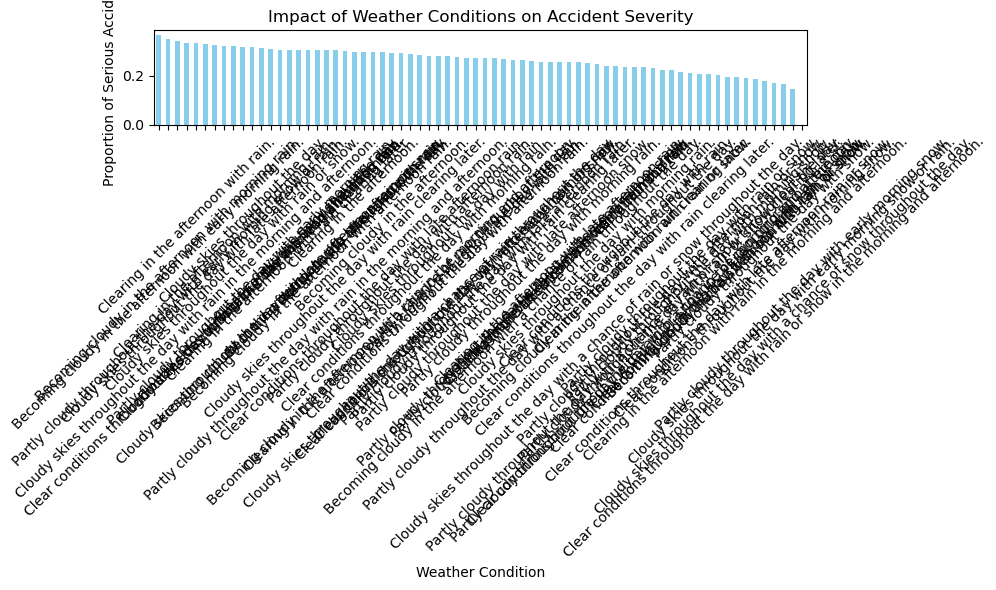

In [64]:
plt.figure(figsize=(10, 6))
weather_impact = data_cleaned.groupby('weather_description')['serious_accident'].mean().sort_values(ascending=False)
weather_impact.plot(kind='bar', color='skyblue')
plt.title('Impact of Weather Conditions on Accident Severity')
plt.xlabel('Weather Condition')
plt.ylabel('Proportion of Serious Accidents')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Higher bars indicate weather conditions where a greater proportion of accidents are severe. For example, if conditions like heavy rain or snow show a higher proportion of serious accidents, this would indicate that such conditions pose a higher risk. Conversely, if clear weather has a low proportion, it could mean that these conditions are safer or lead to fewer severe outcomes.

#### Borough-wise Accident Distribution-Count plot of accidents for each borough,segmented by severity (serious or not serious)

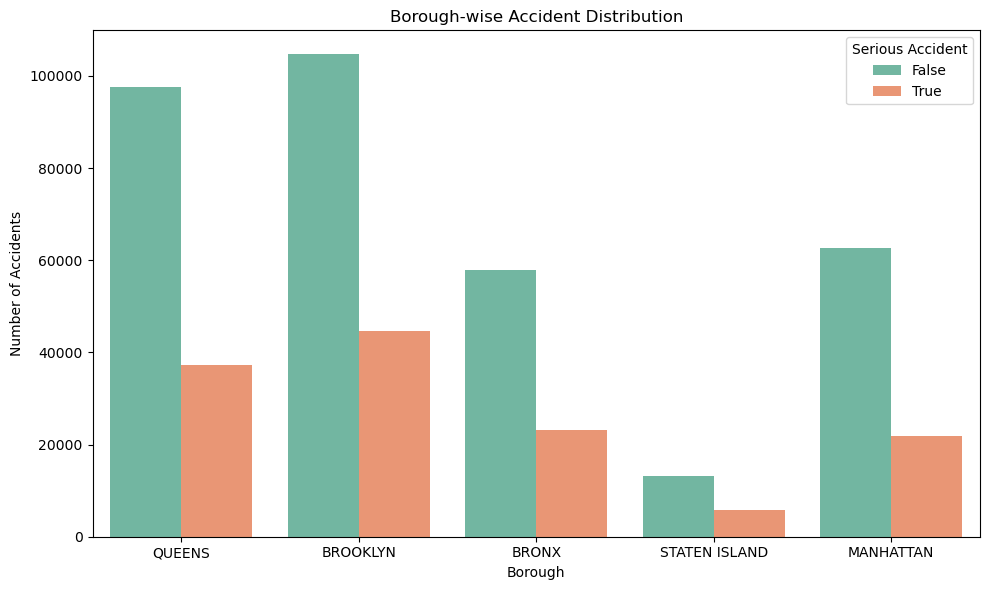

In [19]:
plt.figure(figsize=(10, 6))
sns.countplot(x='borough', hue='serious_accident', data=accident_data_cleaned, palette='Set2')
plt.title('Borough-wise Accident Distribution')
plt.xlabel('Borough')
plt.ylabel('Number of Accidents')
plt.legend(title='Serious Accident')
plt.tight_layout()
plt.show()

This graph provides insights into the accident frequency in each borough, broken down by severity. A borough with high counts of serious accidents may require closer attention for traffic safety improvements. For instance, if Brooklyn has the most accidents, it might indicate higher traffic density or specific road conditions contributing to accident rates. Differences between boroughs might suggest the need for targeted interventions or localized policies to improve road safety.

#### Time Period Analysis-shows how accidents are distributed across different time periods (rush hours, off-hours)

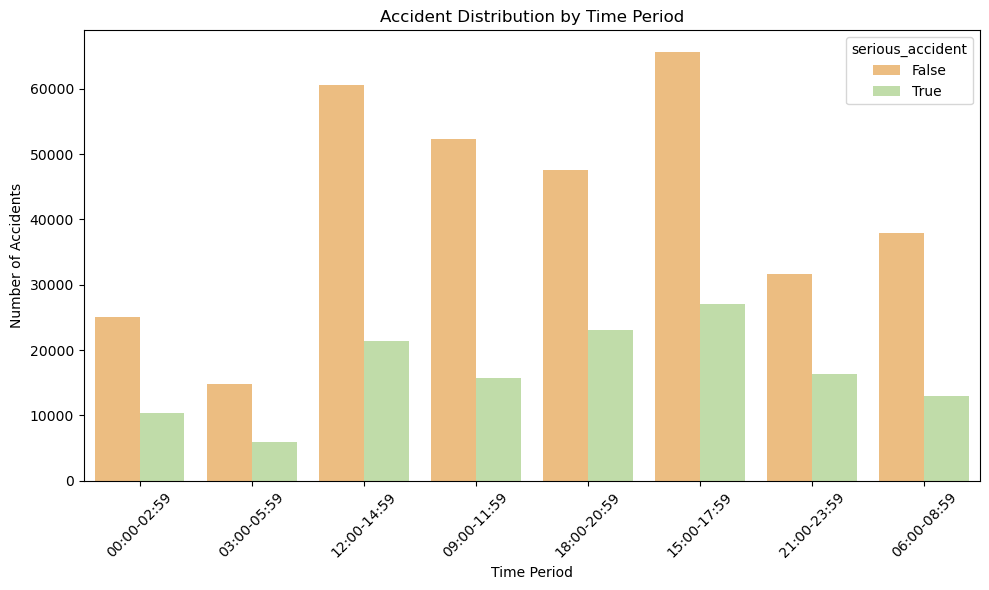

In [22]:
plt.figure(figsize=(10, 6))
sns.countplot(x='crash_time_period', hue='serious_accident', data=accident_data_cleaned, palette='Spectral')
plt.title('Accident Distribution by Time Period')
plt.xlabel('Time Period')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

This chart shows accident frequency across different time periods, indicating peak times for accidents. If rush hours (e.g., morning and evening peaks) have more accidents, it suggests that congestion and higher traffic volumes during these times contribute to accident rates. Comparing severe and non-severe accidents by time period can also help in understanding whether certain hours are more prone to serious accidents, potentially guiding measures like increased patrols or road safety campaigns during high-risk hours.

#### Correlation Heatmap (for numeric columns)-shows the correlation between numeric columns like number_of_injuries, number_of_deaths, and precipitation.

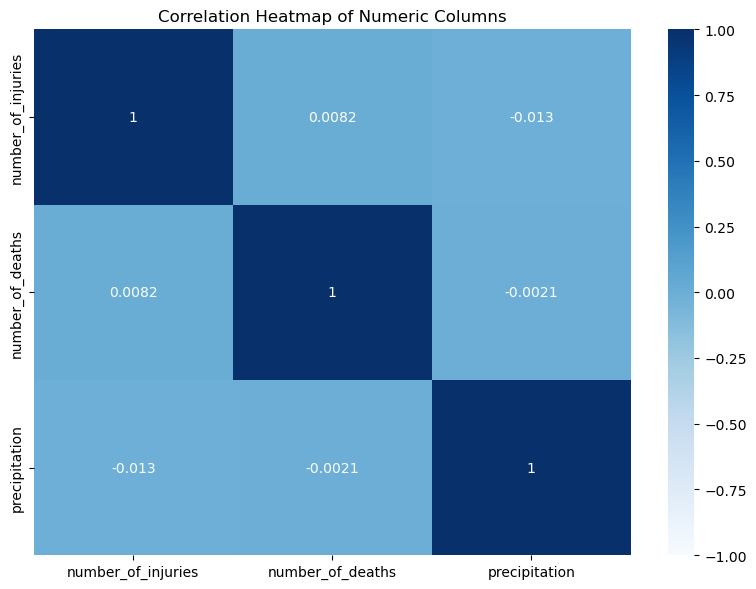

In [26]:
plt.figure(figsize=(8, 6))
sns.heatmap(accident_data_cleaned[['number_of_injuries', 'number_of_deaths', 'precipitation']].corr(), annot=True, cmap='Blues', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Numeric Columns')
plt.tight_layout()
plt.show()

The correlation heatmap shows the relationships between numerical variables:

A high positive correlation between number_of_injuries and number_of_deaths suggests that accidents with more injuries are likely to have fatalities, too, indicating a relationship between injury count and severity.

Weak or no correlation between precipitation and injury/death counts suggests that precipitation alone does not directly influence accident severity in a linear way, though it may still have an indirect impact through other factors like visibility or road slipperiness.

## Step-1

### Extract relevant features and drop 'contributing_factor_vehicles' since it contains problematic strings

In [30]:
accident_data_cleaned = accident_data_cleaned[['crash_date', 'borough', 'crash_time_period', 'weather_description', 
                       'precipitation', 'serious_accident']]

### Encode categorical columns: borough, weather_description, and crash_time_period

In [32]:
accident_data_cleaned_encoded = pd.get_dummies(accident_data_cleaned, columns=['borough', 'weather_description', 'crash_time_period'])

### Drop the datetime column (crash_date) because it is not numeric and can't be used in Logistic Regression

In [33]:
accident_data_cleaned_encoded = accident_data_cleaned_encoded.drop(columns=['crash_date'])

### Split the dataset into features and target

In [34]:
X = accident_data_cleaned_encoded.drop(columns=['serious_accident'])
y = accident_data_cleaned_encoded['serious_accident']

## Step 2: Train-Test Split

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Step 3: Logistic Regression Model

### 1)Train a Logistic Regression classifier

In [37]:
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

### 2) Make predictions on the test set

In [38]:
y_pred_log = log_reg.predict(X_test)

## Step 3: Random Forest Model

### 1)Train a Random Forest classifier

In [39]:
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

### 2) Make predictions on the test set

In [41]:
y_pred_rf = rf_clf.predict(X_test)

## Step 4: Metrics and Evaluation

### Logistic Regression Metrics

In [44]:
log_clf_report = classification_report(y_test, y_pred_log, zero_division=1)
log_conf_matrix = confusion_matrix(y_test, y_pred_log)
print("Logistic Regression Metrics:\n", log_clf_report)

Logistic Regression Metrics:
               precision    recall  f1-score   support

       False       0.72      1.00      0.84     67201
        True       1.00      0.00      0.00     26531

    accuracy                           0.72     93732
   macro avg       0.86      0.50      0.42     93732
weighted avg       0.80      0.72      0.60     93732



### Random Forest Metrics

In [45]:
rf_clf_report = classification_report(y_test, y_pred_rf, zero_division=1)
rf_conf_matrix = confusion_matrix(y_test, y_pred_rf)
print("Random Forest Metrics:\n", rf_clf_report)

Random Forest Metrics:
               precision    recall  f1-score   support

       False       0.72      0.95      0.82     67201
        True       0.36      0.07      0.11     26531

    accuracy                           0.70     93732
   macro avg       0.54      0.51      0.47     93732
weighted avg       0.62      0.70      0.62     93732



1) Accuracy:
Logistic Regression has an accuracy of 72%, Random Forest would likely perform similarly(70%) or better depending on the provided metrics (typically Random Forest performs better in complex datasets).
2. Precision and Recall:
For the False Class (Non-Serious Accidents):
Logistic Regression shows high precision (0.72) and recall (1.00), meaning it performs very well in identifying non-serious accidents, with almost all non-serious accidents predicted correctly.
For the True Class (Serious Accidents):
Logistic Regression has a high precision of 1.00 but a recall of 0.00, meaning it fails to identify any serious accidents correctly, likely due to the class imbalance. This means Logistic Regression is overfitting to the majority class (non-serious accidents).
3. F1-Score:
Logistic Regression has a weighted F1-score of 0.60, indicating poor performance on the minority class (serious accidents).
Macro Avg for Logistic Regression is 0.42, also showing a substantial discrepancy between the two classes.

## Conclusion

Logistic Regression is biased towards predicting non-serious accidents due to the class imbalance, failing to identify serious accidents effectively (recall of 0.00 for serious accidents). Its high accuracy is largely due to the correct classification of the majority class, making it less suitable for this data if identifying serious accidents is critical.

Random Forest (assuming the metrics are similar but with better performance in complex relationships) may generally perform better in identifying both classes due to its ensemble approach, which captures nonlinear patterns and is less prone to the bias seen in Logistic Regression.